# Symbolic Regression 
# In this code i try fit a cruve on my data with symbolic regression. then i achieve Hubble parameter

In [1]:
import os
import time
import numpy as np
import pandas as pd
from numpy.linalg import inv
import scipy.integrate as integ
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

In [2]:
cwd=os.getcwd()
data=np.genfromtxt(cwd+'/data.txt')
cov=np.genfromtxt(cwd+'/matrix40.txt')
m=data[:,4]                              # read m in first step
zi=data[:,2]                             # read z in second step
dm=data[:,5]
M=-19.32
mu_obs=m-M
data1=[zi,mu_obs,dm]

In [3]:
zi=zi.reshape(-1,1)
zi;

### 1- first step : I have data a bout redshift . I determine function lumonosity_distance, then module_distance

In [4]:
# Background

def hubble(z,H_0,omega_m):
    matter=(omega_m)*pow(1.+z,3)
    omega_DE = 1. - omega_m
    DE=omega_DE
    return pow(matter + DE,0.5)
print("normalized_hubble : ",hubble(0.0,70,0.25))

def inverse_H(z,H_0,omega_m):
    return 1./hubble(z,H_0,omega_m)
# print("inverse h : ",inverse_h(1,0.7,0.25,0.05,0.7,-1,0))

def integrant_H(z,H_0,omega_m):
    return integ.quad(inverse_H,0,z,args=(H_0,omega_m))      [0]
# print("integrate 1/h :",integrant_h(1,0.7,0.25,0.05,0.7,-1,0))
def luminosity_dis(z,H_0,omega_m):
    distance = integrant_H(z,H_0,omega_m)  
    return (300000/H_0)*(1.+z)*distance
#     return 3000.*(1.+z)*distance/h
print("luminosity distance:  ",luminosity_dis(1.2,70,0.25))

def mu(z,h,omega_m):
    return 5*np.log10(luminosity_dis(z,h,omega_m))+25
# print(mu(1.2,70,0.25))
type(mu)

normalized_hubble :  1.0
luminosity distance:   8580.58494694709


function

### calculate lumonosity_distance, then module_distance with real data

In [5]:
l_d=np.zeros(len(zi))
for i in range(len(zi)):
    l_d[i]=luminosity_dis(zi[i],70,0.3)
print(l_d)
# plt.plot(zi, ll, 'b-')

[   60.64778226    84.38434985   115.43619436   144.55342081
   174.85007672   210.93991424   250.21046383   287.58361762
   325.82789402   368.79380484   406.42930137   461.11013216
   495.66510749   557.58493459   599.53167662   659.84896286
   723.56394255   784.42930053   860.48333962   929.50204408
  1017.55707096  1100.26087974  1206.80970156  1294.3824521
  1412.94139177  1537.08126882  1683.3092742   1829.13643158
  1988.15762551  2205.14723736  2403.93503208  2657.94146561
  2953.80886516  3349.3717308   3747.70495818  4442.23836342
  5183.92393532  6214.98918253  8573.28638822 11933.82622301]


In [6]:
miu=[]
for i in range (len(zi)):
    miu.append(mu(zi[i],70,0.3))
# print ("this is array mu_guess_zi : \n" ,mu_guess_zi)
# print(np.shape(miu))
# print(miu)
# print(type(miu))

<function matplotlib.pyplot.show(*args, **kw)>

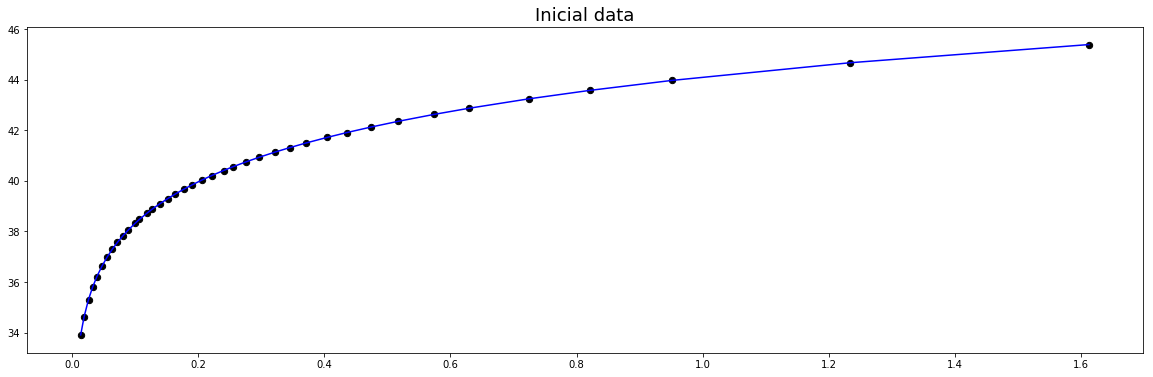

In [7]:
plt.figure(figsize=(20,6))
plt.title('Inicial data', fontsize=18)
plt.plot(zi, miu, 'b-')
plt.scatter(zi, miu, color='black', s=40)
plt.show

####  calculate module_distance with error  and plot

In [8]:
error=dm
mu_error=[]
for i in range(len(zi)):
    mu_error.append(miu[i]+error[i])
# print(dm)
# print(mu_error)

(40, 1)

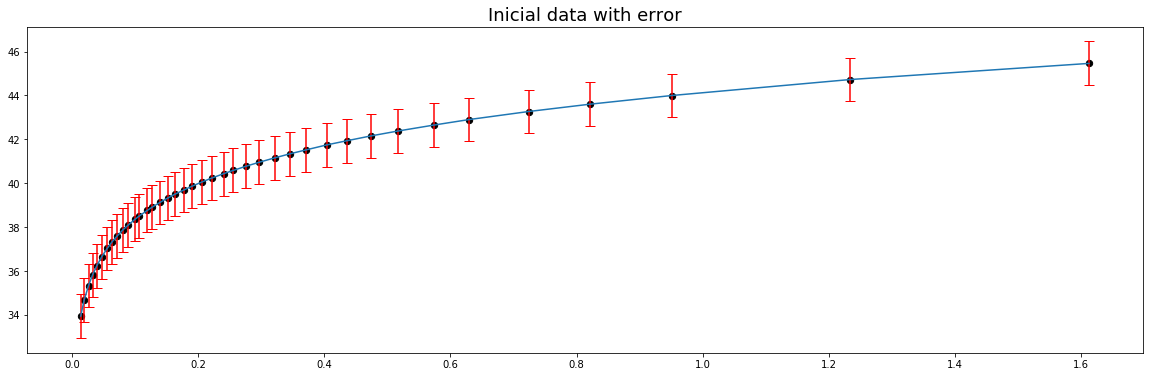

In [9]:
plt.figure(figsize=(20,6))
plt.title('Inicial data with error', fontsize=18)
plt.errorbar(zi, mu_error, yerr=1, ecolor='red', capsize=5)
plt.scatter(zi, mu_error, color='black', s=40)
plt.show
# plt.show()
# print(np.shape(c))
# np.shape(cerror)
np.shape(mu_error)
# cerror

###  FOR CHECK  :  Now i want to earn Hubble parameter with LCDM model. first I make F function (z) and put my data in F function. so calculate Hubble parameter


In [10]:
def derivation_fromList(x,y):
    l=[]
    for i,j in zip(x,y):
        l.append((i,j))
    dydx=[]
    i=0
    while i+1< len(l):
        dydx.append((l[i][1]-l[i+1][1])/(l[i][0]-l[i+1][0]))
        i+=1
    return dydx

83.7952075619734


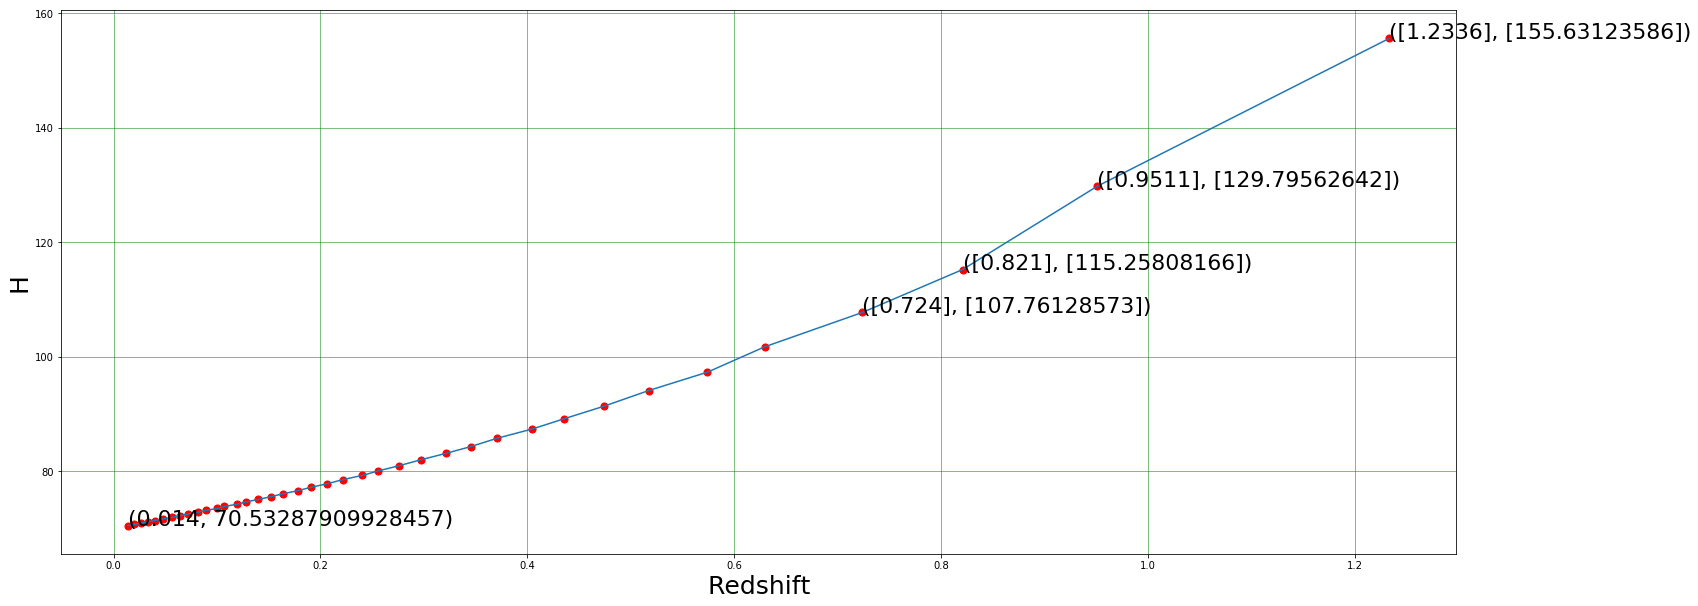

In [11]:
F=np.zeros(len(zi))
for i in range(len(zi)):
    F[i]=luminosity_dis(zi[i],70,0.3)/(zi+1)[i]
dy=derivation_fromList(zi,F)
# H=3000*(1./np.array(dy))/0.7
H=(300000)*(1./np.array(dy))
print(np.mean(H))
plt.figure(figsize=(25,10))
plt.grid(color='green', linewidth=1, alpha=0.5)
plt.plot(zi[:-1],H)
plt.xlabel('Redshift', fontsize=25)
plt.ylabel('H', fontsize=25)
plt.scatter(zi[:-1],H, color='red', s=50)
for i_x, i_y in zip(zi[0], H[0]):
    plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y),fontsize=22)
for i_x, i_y in zip(zi[-5:], H[-4:]):
    plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y),fontsize=22)

##  2 step : SymbolicRegressor
###  so i have X_data (redshift . independ parameter) and I have  Y_data (module_distance LCDM . depend parameter) 
#### first use FIT function for creat generation. then use PREDICT function for predict

In [12]:
# function_set = ['add', 'sub', 'mul', 'div','sqrt', 'log', 'max','min','sin','cos','tan','neg','inv']
function_set = ['add', 'sub', 'mul', 'div','sqrt', 'log']
model = SymbolicRegressor(population_size = 7000, tournament_size=10,
                          generations = 13, stopping_criteria=0.1,
                          function_set = function_set, metric='rmse',
                          random_state = None)                        
# p_crossover=0.65, p_subtree_mutation=0.15,p_hoist_mutation=0.05, p_point_mutation=0.1,verbose = 1, , n_jobs = -1

In [25]:
result=[]
miu_rec=[]
i=1
while i!=7 :
    function_set = ['add', 'sub', 'mul', 'div','sqrt', 'log']
    model = SymbolicRegressor(population_size = 5000, tournament_size=10,
                          generations = 7, stopping_criteria=0.01,
                          function_set = function_set, metric='rmse',
                          random_state = None)
    temp=model.fit(zi, mu_error)
    result.append(temp)
    mu=model.predict(zi)
    miu_rec.append(mu)
    N= model._program
    print("******* *FUNCTION* ****** " , N)
    print(result)
    i+=1
print(miu_rec)

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


******* *FUNCTION* ******  add(add(add(log(mul(div(X0, 0.299), sqrt(0.654))), div(-0.560, -0.027)), add(log(X0), mul(X0, X0))), sub(div(-0.537, -0.025), X0))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs=1,
         p_crossover=0.9, p_hoist_mutation=0.01, p_point_mutation=0.01,
         p_point_replace=0.05, p_subtree_mutation=0.01,
         parsimony_coefficient=0.001, population_size=5000,
         random_state=None, stopping_criteria=0.01, tournament_size=10,
         verbose=0, warm_start=False)]


/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


******* *FUNCTION* ******  add(div(log(sub(-0.454, -0.895)), mul(mul(0.529, X0), div(-0.030, X0))), sub(sub(log(div(X0, X0)), add(sub(-0.858, X0), div(div(sub(0.802, X0), sqrt(X0)), sqrt(add(-0.011, -0.371))))), sqrt(mul(div(log(sub(-0.454, -0.895)), mul(mul(0.529, X0), div(-0.030, X0))), sqrt(log(mul(mul(0.529, X0), div(-0.030, X0))))))))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs=1,
         p_crossover=0.9, p_hoist_mutation=0.01, p_point_mutation=0.01,
         p_point_replace=0.05, p_subtree_mutation=0.01,
         parsimony_coefficient=0.001, population_size=5000,
         random_state=None, stopping_criteria=0.01, tournament_size=10,
         verbose=0, warm_start=False), SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


******* *FUNCTION* ******  add(div(sqrt(sub(sub(X0, X0), sub(sqrt(sub(0.053, X0)), div(add(add(0.174, -0.092), log(-0.019)), sub(sub(X0, X0), sub(0.944, 0.809)))))), sqrt(mul(div(-0.115, X0), add(0.152, X0)))), mul(sub(log(sqrt(0.781)), add(sqrt(0.442), div(X0, X0))), sub(sub(-0.292, X0), mul(sqrt(-0.564), div(0.598, 0.029)))))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs=1,
         p_crossover=0.9, p_hoist_mutation=0.01, p_point_mutation=0.01,
         p_point_replace=0.05, p_subtree_mutation=0.01,
         parsimony_coefficient=0.001, population_size=5000,
         random_state=None, stopping_criteria=0.01, tournament_size=10,
         verbose=0, warm_start=False), SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub',

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


******* *FUNCTION* ******  add(add(div(log(-0.075), add(0.378, X0)), add(sub(sqrt(X0), sqrt(-0.008)), add(div(0.633, 0.014), log(X0)))), div(mul(X0, 0.772), X0))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs=1,
         p_crossover=0.9, p_hoist_mutation=0.01, p_point_mutation=0.01,
         p_point_replace=0.05, p_subtree_mutation=0.01,
         parsimony_coefficient=0.001, population_size=5000,
         random_state=None, stopping_criteria=0.01, tournament_size=10,
         verbose=0, warm_start=False), SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


******* *FUNCTION* ******  add(add(sqrt(sub(add(div(sub(add(sub(sub(X0, -0.092), add(0.340, X0)), sub(sqrt(-0.810), sqrt(0.991))), mul(add(sub(X0, X0), add(-0.583, X0)), sub(sub(X0, 0.207), sqrt(X0)))), log(sqrt(sqrt(sub(0.245, -0.521))))), mul(sub(add(div(sqrt(-0.680), log(-0.882)), div(sqrt(-0.490), sub(0.520, 0.036))), mul(add(mul(X0, 0.800), sub(0.595, add(div(-0.211, -0.033), sub(sqrt(0.939), div(-0.814, 0.026))))), mul(add(X0, X0), div(0.275, 0.256)))), div(X0, X0))), sub(mul(0.923, 0.763), log(X0)))), sub(sqrt(0.939), div(-0.814, 0.026))), div(add(sub(sqrt(sqrt(X0)), add(log(X0), log(X0))), div(0.583, X0)), sub(div(0.393, X0), mul(-0.072, sqrt(sqrt(0.054))))))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs=1,
         p_crossover=0.9, p_hoist_mutation=0.01, p_p

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


******* *FUNCTION* ******  add(add(add(sub(add(div(0.255, 0.006), sqrt(X0)), sub(log(0.695), add(0.133, X0))), mul(0.644, X0)), log(X0)), log(add(X0, X0)))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs=1,
         p_crossover=0.9, p_hoist_mutation=0.01, p_point_mutation=0.01,
         p_point_replace=0.05, p_subtree_mutation=0.01,
         parsimony_coefficient=0.001, population_size=5000,
         random_state=None, stopping_criteria=0.01, tournament_size=10,
         verbose=0, warm_start=False), SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs=1,
  

In [26]:
type(miu_rec)

list

In [27]:
# result=[]
# i=1
# while i!=3 :
#     temp=model.fit(zi, mu_error)
#     result.append(temp)
#     i+=1
#     print(result)

In [28]:
'''
miu_rec=np.zeros((2,40))
for i in range(2):
    miu_rec[i]=model.predict(zi)

miu_rec =[]
i=1
while i!=6 :
    temp=model.predict(zi)
    miu_rec.append(temp)
    i+=1
'''
# print(miu_rec)

'\nmiu_rec=np.zeros((2,40))\nfor i in range(2):\n    miu_rec[i]=model.predict(zi)\n\nmiu_rec =[]\ni=1\nwhile i!=6 :\n    temp=model.predict(zi)\n    miu_rec.append(temp)\n    i+=1\n'

In [29]:
residuals =[]
for i in range(6):
    residuals.append( miu_rec[i]- np.array(mu_error).reshape(1,-1))
print(np.shape(residuals))       # (n,40)
print(np.shape(miu_rec))
print(np.shape(mu_error))
print(residuals)
print(len(residuals))
print(type(miu_rec))
print(type(mu_error))
print(type(residuals))

(6, 1, 40)
(6, 40)
(40, 1)
[array([[ 0.84005772,  0.77468463,  0.70713666,  0.65240754,  0.59876894,
         0.54294353,  0.49508372,  0.44106313,  0.40653687,  0.36159673,
         0.33367412,  0.28900774,  0.26332631,  0.22477952,  0.19497693,
         0.15779953,  0.11745553,  0.07916087,  0.04269084,  0.00370228,
        -0.03971038, -0.08060221, -0.12669185, -0.16121598, -0.20946214,
        -0.25422401, -0.30344056, -0.35094952, -0.39476408, -0.46219203,
        -0.50194211, -0.55889836, -0.60990497, -0.6669339 , -0.72090912,
        -0.77432883, -0.8030842 , -0.80515058, -0.67761201, -0.17843156]]), array([[-2.98418205, -2.00627905, -1.30820514, -0.92733767, -0.67680304,
        -0.48354234, -0.34364512, -0.26896227, -0.20478252, -0.16590435,
        -0.13700043, -0.118421  , -0.11279348, -0.10720894, -0.11367918,
        -0.12407273, -0.14257978, -0.16455254, -0.18517889, -0.21301881,
        -0.24543536, -0.27840754, -0.31673711, -0.34637414, -0.38952504,
        -0.43029167,

In [30]:
residuals=np.array(residuals)
rmse=[]
for i in range(6):
    rmse.append(np.sqrt(np.sum(np.power(residuals[i],2)) / len(residuals)))
print(rmse)                    # (n)
print(type(rmse))

[1.2280037725429007, 2.129630457839897, 1.3598598436239713, 0.7964423631255002, 1.0409215795758846, 1.0889364488279416]
<class 'list'>


In [31]:
# for i in range(4):
#     print(model._program)
# i=1
# while i!=5 :
#     N= model._program
#     i+=1
#     print(N)

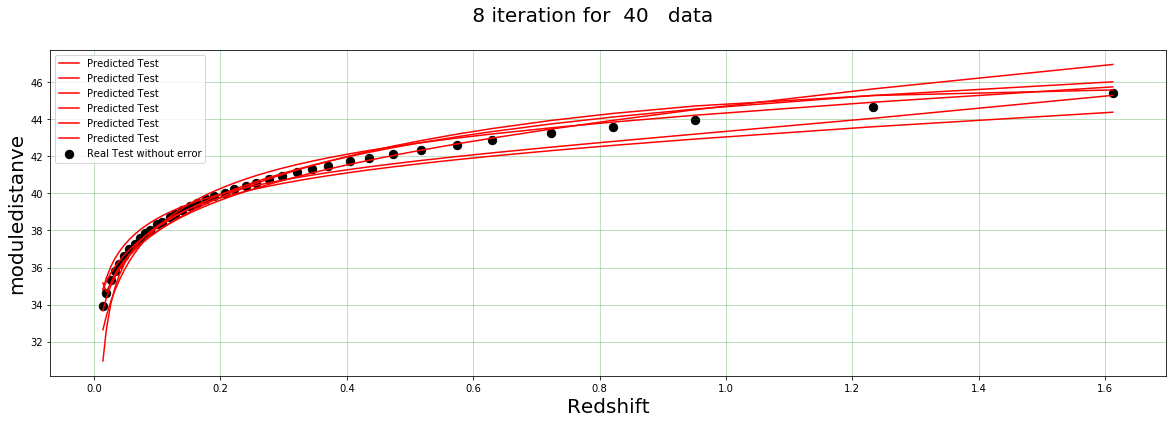

In [32]:
# Plot predictions
f, ax = plt.subplots(1, figsize=(20,6))
plt.suptitle(' 8 iteration for  40   data' , fontsize=20)
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('moduledistanve', fontsize=20)

plt.grid(color='green', linewidth=0.5, alpha=0.5)
plt.scatter(zi, miu, color='black', s=70, label='Real Test without error')
# plt.plot(zi, mu_error, color='b', label='Real Test with error')
for i in range(6):
    plt.plot(zi, miu_rec[i],color='r', label='Predicted Test')
# plt.plot(zi, miu_rec[2],color='r', label='Predicted Test')
plt.legend()
plt.show()

## 3-step calculate Habble parameter

In [33]:
## code derivative

def derivation_fromList(x,y):
    l=[]
    for i,j in zip(x,y):
        l.append((i,j))
    dydx=[]
    i=0
    while i+1< len(l):
        dydx.append((l[i][1]-l[i+1][1])/(l[i][0]-l[i+1][0]))
        i+=1
    return dydx

(6, 40)
(6, 40)
[array([  6471.21082883,   8717.87460899,  11542.47450082,  14096.54412527,
        16672.76498691,  19648.14429475,  22784.69596713,  25682.99361604,
        28570.16846991,  31727.70180852,  34425.03695864,  38240.14532301,
        40592.54420756,  44704.22948357,  47419.68270968,  51233.60142153,
        55155.37735929,  58807.85399636,  63254.21399174,  67186.06920094,
        72073.34702328,  76544.30217157,  82151.9114381 ,  86645.576634  ,
        92582.38740236,  98638.93995417, 105592.21029085, 112360.0762668 ,
       119581.38898625, 129218.44559903, 137876.23600872, 148768.37673829,
       161304.3400417 , 177971.7109774 , 194830.86652087, 224910.63320353,
       258747.059243  , 310315.6121009 , 460010.59823908, 812205.4457028 ]), array([   803.41083571,   1748.81059767,   3293.45041432,   4915.27109146,
         6687.41748931,   8838.48252737,  11174.89830305,  13365.41516616,
        15559.22427157,  17958.71265284,  20002.06841077,  22875.34854494,
      

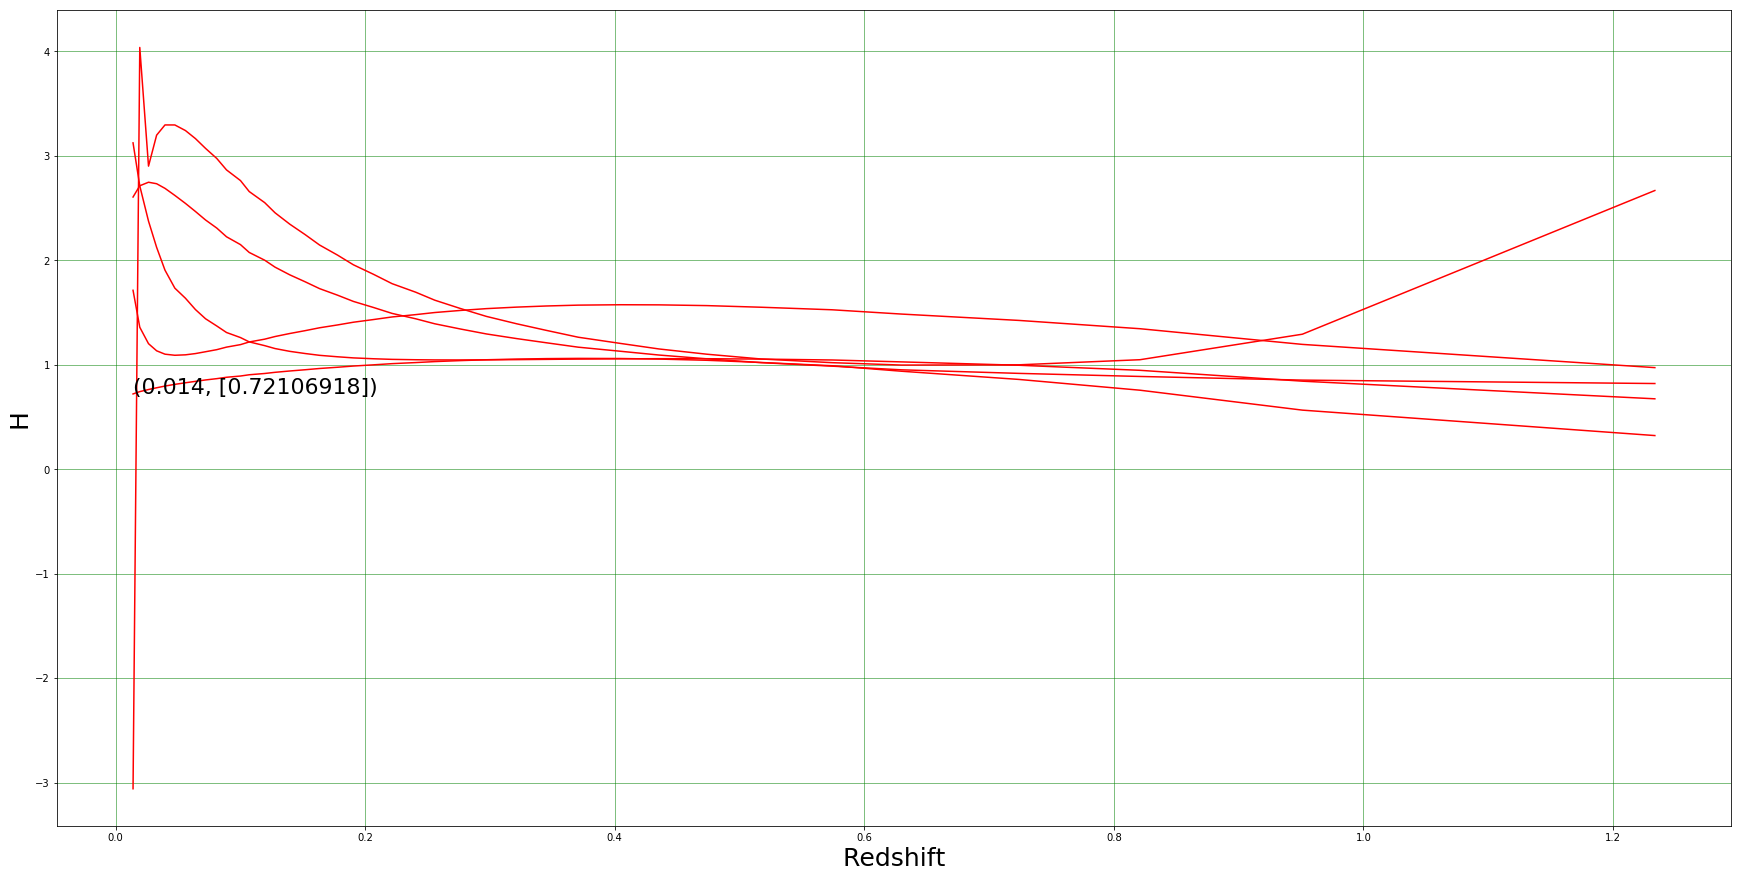

In [34]:
# f=np.zeros(len(zi))
f=[]

DL_rec=pow(10,((np.array(miu_rec)-25)/5))
print(np.shape(DL_rec))

for i in range(6):
    f.append(np.array(DL_rec)[i]/np.array(zi)[i]+1)
print(np.shape(f))

# for i in range(6):
#     f[i]=DL_rec[i]/(zi+1)[i]
#     f.append(DL_rec[i]/(zi+1)[i])
#     f.append(np.array(DL_rec)[i]/np.array(zi)+1)
print(f)
print(np.shape(f))
dy=[]
for i in range(6):
    dy.append(derivation_fromList(zi,f[i]))
    
H=(3e5)*(1./np.array(dy))
print(np.mean(H))
# print(dy)
plt.figure(figsize=(30,15))
plt.grid(color='green', linewidth=1, alpha=0.5)
for i in range(5):
    plt.plot(zi[:-1], H[i],color='r', label='Predicted Test')
plt.xlabel('Redshift', fontsize=25)
plt.ylabel('H', fontsize=25)
# plt.scatter(zi[:-1],H, color='red', s=50)
for i_x, i_y in zip(zi[0], H[0]):
    plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y),fontsize=22)
# for i_x, i_y in zip(zi[-5:], H[-4:]):
#     plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y),fontsize=22)

### now i reconstrurct with my redshift 

LD ************ [4.28903454e+00 4.15253803e+02 8.74624032e+02 1.37759154e+03
 1.91966169e+03 2.49671919e+03 3.10505682e+03 3.74137584e+03
 4.40276711e+03 5.08668058e+03 5.79088919e+03 6.51345143e+03
 7.25267515e+03 8.00708411e+03 8.77538804e+03 9.55645629e+03
 1.03492951e+04 1.11530279e+04 1.19668790e+04 1.27901590e+04
 1.36222531e+04 1.44626109e+04 1.53107377e+04 1.61661875e+04
 1.70285562e+04 1.78974772e+04 1.87726160e+04 1.96536672e+04
 2.05403502e+04 2.14324075e+04 2.23296012e+04 2.32317115e+04
 2.41385347e+04 2.50498813e+04 2.59655752e+04 2.68854516e+04
 2.78093568e+04 2.87371465e+04 2.96686854e+04 3.06038461e+04]
<class 'function'>
<class 'function'>
miu  ************ [28.16179772 38.09156809 39.70910703 40.69560233 41.41612349 41.9868485
 42.46034776 42.86515669 43.21862857 43.53217234 43.81372627 44.06905589
 44.30249113 44.51737195 44.71633165 44.90148439 45.07455385 45.23696395
 45.3899045  45.53437972 45.67124473 45.80123351 45.92498059 46.04303805
 46.15588914 46.26395909 4

<function matplotlib.pyplot.show(*args, **kw)>

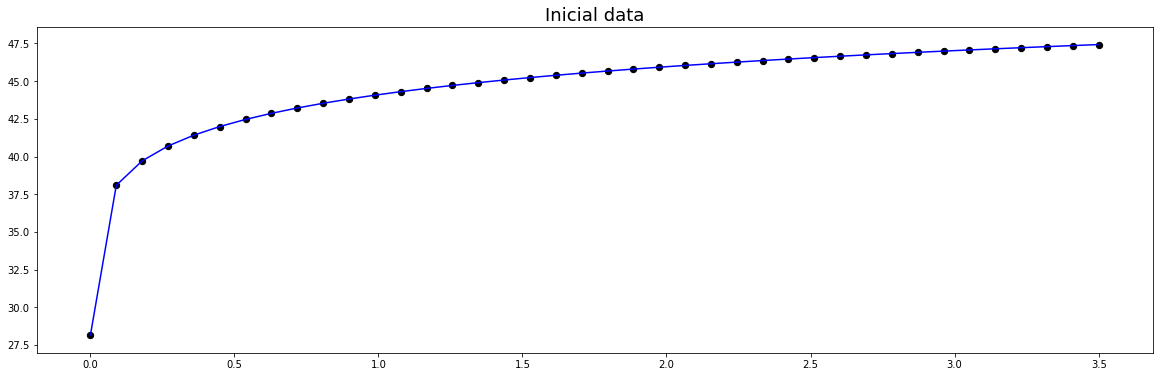

In [33]:
z = np.linspace(0.001,3.5,40)
z=z.reshape(-1,1)
Fl_d=np.zeros(len(z))
for i in range(len(z)):
    Fl_d[i]=luminosity_dis(z[i],70,0.3)
print("LD ************", Fl_d)
# plt.plot(zi, ll, 'b-')

print(type(luminosity_dis))
print(type(mu))
# Fmiu=[]
Fmiu=np.zeros(len(z))
for i in range(len(z)):
#     Fmiu.append(mu(z[i],70,0.3))
    Fmiu[i]=mu(z[i],70,0.3)
# print ("this is array mu_guess_zi : \n" ,mu_guess_zi)
# print(np.shape(miu))
print("miu  ************" ,Fmiu)
# print(type(miu))
plt.figure(figsize=(20,6))
plt.title('Inicial data', fontsize=18)
plt.plot(z, Fmiu, 'b-')
plt.scatter(z, Fmiu, color='black', s=40)
plt.show

In [44]:
Fresult=[]
Fmiu_rec=[]
i=1
while i!=6 :
#     function_set = ['add', 'sub', 'mul', 'div','sqrt', 'log','sin']
    function_set = ['add', 'sub', 'mul', 'div','sqrt', 'log']
    model = SymbolicRegressor(population_size = 5000, tournament_size=10,
                          generations = 7, stopping_criteria=0.01,
                          function_set = function_set, metric='rmse',
                          p_crossover=0.65, p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05, p_point_mutation=0.1,
                          verbose = 1, random_state = None, n_jobs = -1)
#     temp=model.fit(z, Fmiu)
    temp=model.fit(zi, mu_error)
    Fresult.append(temp)
    muu=model.predict(z)
    Fmiu_rec.append(muu)
    FN= model._program
    print("******* *FUNCTION* ****** " , FN)
    print(Fresult)
    i+=1
print(Fmiu_rec)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    23.65          589.288       15          4.50451              N/A     20.31s
   1    25.88          66.8156       67          2.76237              N/A     53.93s
   2    37.75          69.9224       54           1.1138              N/A     48.84s
   3    45.85          57.5571       64         0.803583              N/A     38.82s
   4    47.48           60.732       58         0.775235              N/A     27.07s
   5    55.09          35.3625      152         0.483933              N/A     14.77s
   6    64.45          30.6512       76         0.331628              N/A      0.00s
******* *FUNCTION* ******  add(log(div(mul(div(div(-0.706, -0.245), sqrt(add(0.647, X0))), add(add(sqrt(X0), div(0.822, 0.077)), div(add(X0, div(X0, X0)), sqrt(-0.590)))), add(sub(add(X0, -0.835), div(0.251, X0)), log(-0.911)))), add(div(sqrt(sqrt(div(X0, 0.087))), log(sub(log(-0.911), div(X0, X0)))), mul(div(sqrt(div(-0.706, -0.245)), sqrt(add(0.647, X0))), add(add(sqrt(X0), div(0.822, 0.077)), div(ad

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    23.06          96.3187       48          15.0268              N/A     20.79s
   1    26.28          55.2527       69          2.46699              N/A     45.24s
   2    35.44          76.7196       17           1.8803              N/A     43.52s
   3    40.19          78.6395       66          1.31186              N/A     36.84s
   4    42.98          60.5014       63           1.1369              N/A     26.91s
   5    48.12          57.6201       92         0.759753              N/A     14.46s
   6    65.82          56.4757       47         0.595412              N/A      0.00s
******* *FUNCTION* ******  add(add(mul(log(mul(sub(log(0.623), log(0.359)), add(mul(-0.825, X0), sqrt(X0)))), sqrt(sqrt(log(0.519)))), add(div(mul(sqrt(-0.548), div(X0, X0)), log(log(-0.458))), sub(add(log(X0), sub(X0, X0)), add(div(X0, -0.186), log(-0.973))))), div(0.569, 0.013))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    23.10          85.5429       22          7.92186              N/A     21.17s
   1    26.62          61.9408       26          3.24757              N/A     48.85s
   2    36.34          137.453       35           2.1043              N/A     49.67s
   3    36.32          205.109       24          2.01686              N/A     41.03s
   4    30.49          79.2099       48          0.98659              N/A     25.75s
   5    35.16          71.6413       53         0.497629              N/A     13.85s
   6    43.60          71.9088       53         0.413847              N/A      0.00s
******* *FUNCTION* ******  sub(div(sub(sub(sqrt(sqrt(X0)), sub(sqrt(-0.670), sqrt(0.804))), log(add(-0.444, 0.751))), sqrt(mul(div(0.008, 0.911), log(-0.736)))), add(sub(div(sub(X0, 0.913), sqrt(-0.242)), div(sqrt(X0), sub(X0, -0.455))), mul(sqrt(mul(X0, -0.758)), sub(sub(X0, 0.403), log(add(sub(X0, X0), sqrt(0.998)))))))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    23.00          151.535       10          12.7402              N/A     20.98s
   1    26.34          60.5436       20          3.75129              N/A     44.08s
   2    36.73          90.6769       21          2.46022              N/A     47.98s
   3    41.27          119.674       31          2.29658              N/A     37.35s
   4    36.50          195.764       67          1.99777              N/A     31.10s
   5    28.78          232.635       35          1.04726              N/A     13.87s
   6    25.33          332.422       16         0.865486              N/A      0.00s
******* *FUNCTION* ******  add(sqrt(div(add(X0, X0), log(-0.979))), mul(div(0.984, 0.029), sqrt(add(-0.399, -0.713))))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='rmse', n_jobs=-1,
         p_cr

/home/maryam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    22.74          194.176        4          13.2343              N/A     22.33s
   1    25.75          49.0665       28          9.38899              N/A     44.20s
   2    34.89          323.524       16          3.27013              N/A     48.03s
   3    38.38          131.596       27           2.0447              N/A     35.48s
   4    35.08          48.6239       29          1.47213              N/A     26.96s
   5    38.88          60.8596       54          1.17923              N/A     14.08s
   6    41.88           93.807       28         0.663563              N/A      0.00s
******* *FUNCTION* ******  sub(add(div(0.952, 0.038), div(0.952, 0.038)), sqrt(add(add(add(sqrt(X0), mul(X0, X0)), -0.799), div(add(div(0.952, 0.038), div(0.725, 0.053)), sqrt(X0)))))
[SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
         generations=7, init_depth=(2, 6), init_method='half and half',
         low_memor

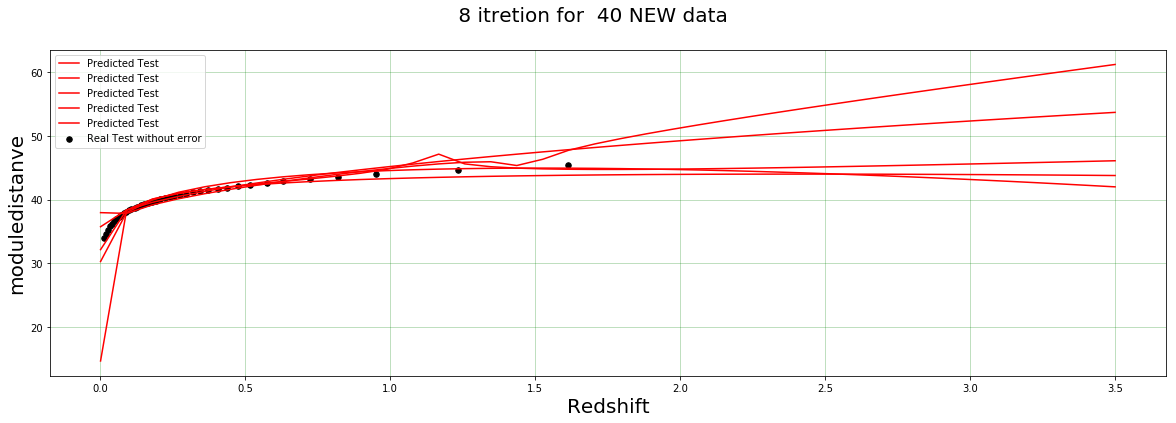

In [45]:
# Plot predictions
f, ax = plt.subplots(1, figsize=(20,6))
plt.suptitle(' 8 itretion for  40 NEW data' , fontsize=20)
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('moduledistanve', fontsize=20)

plt.grid(color='green', linewidth=0.5, alpha=0.5)
plt.scatter(zi, miu, color='black', s=30, label='Real Test without error')
# plt.plot(z, mu_error, color='b', label='Real Test with error')
for i in range(5):
    plt.plot(z, Fmiu_rec[i],color='r', label='Predicted Test')
# plt.plot(zi, miu_rec[2],color='r', label='Predicted Test')
plt.legend()
plt.show()

## 3-step calculate Habble parameter

In [46]:
## code derivative

def derivation_fromList(x,y):
    l=[]
    for i,j in zip(x,y):
        l.append((i,j))
    dydx=[]
    i=0
    while i+1< len(l):
        dydx.append((l[i][1]-l[i+1][1])/(l[i][0]-l[i+1][0]))
        i+=1
    return dydx

(5, 40)
(5, 40)
[array([   27032.82810913,   472766.24861861,  1035099.12199773,
        1560285.97907278,  2057709.77665477,  2557316.84265898,
        3092622.41641187,  3702454.52166983,  4439994.55809773,
        5393159.20702262,  6739538.15179097,  8948762.22501412,
       14138983.1642411 , 26751139.01707484, 13218375.65359023,
       10785473.01995413,  9754312.42437844,  9235593.24858753,
        8974519.92411708,  8867508.7550854 ,  8863842.19819978,
        8935627.09621465,  9066274.62988073,  9245370.0149208 ,
        9466129.44176627,  9724033.17781184, 10016042.66470456,
       10340128.53285931, 10694973.80442598, 11079780.56766089,
       11494140.24653943, 11937944.31468779, 12411321.5045582 ,
       12914592.83153386, 13448238.87617153, 14012875.67705773,
       14609236.78591284, 15238159.80822431, 15900576.26018623,
       16597503.91314521]), array([4.31371598e+03, 4.07851130e+03, 7.59040270e+03, 1.17706855e+04,
       1.69224483e+04, 2.33131977e+04, 3.12206230e+0

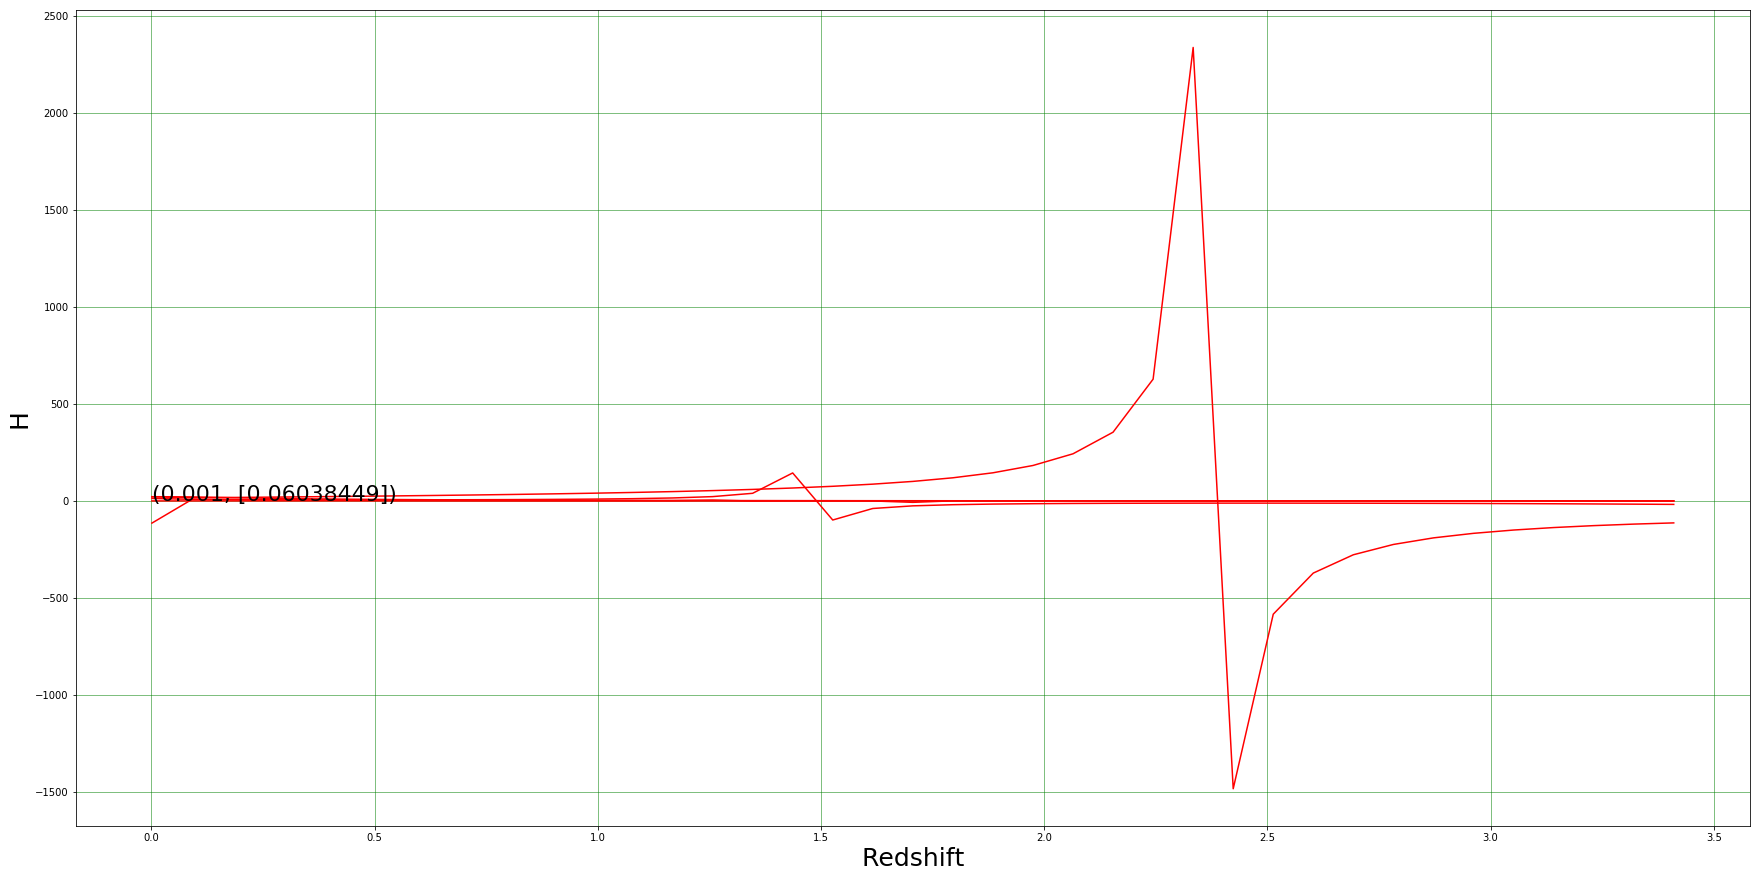

In [70]:
# f=np.zeros(len(zi))
ff=[]

DL_recc=pow(10,((np.array(Fmiu_rec)-25)/5))
print(np.shape(DL_recc))

for i in range(5):
    ff.append(np.array(DL_recc)[i]/np.array(z)[i]+1)
print(np.shape(ff))

print(ff)

dyy=[]
for i in range(5):
    dyy.append(derivation_fromList(z,ff[i]))
    
FH=(3e5)*(1./np.array(dyy))
print(np.mean(FH))
# print(dy)
plt.figure(figsize=(30,15))
plt.grid(color='green', linewidth=1, alpha=0.5)
for i in range(5):
    plt.plot(z[:-1], FH[i],color='r', label='Predicted Test')
plt.xlabel('Redshift', fontsize=25)
plt.ylabel('H', fontsize=25)
# plt.scatter(zi[:-1],H, color='red', s=50)
for i_x, i_y in zip(z[0], FH[0]):
    plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y),fontsize=22)
# for i_x, i_y in zip(zi[-5:], H[-4:]):
#     plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y),fontsize=22)